# AI on the edge

Deep learning on small devices


## About StackUp
---

![stackup](assets/stackup.png)

## AI on the edge
---
- Motivation
- Deep nets for devices
- Running deep nets on devices

## The Why
---
Why run AI on the edge?

<img src='assets/lsvm-machine-learning-cloud.jpg' width='80%'/>

![data center](assets/how_safe_datacenter.jpg)

<img src='assets/GDP-Complience-V02-72dpi-RGB-01.jpg' width='70%'/>

<img src='assets/qualcomm_on_device_intelligence.png' width='80%'/>

## Optimized deep learning models
---
What AI can run on small devices?


*small = smaller than mobile phones

## Optimized deep learning models
---
What AI can run *in real time* on small devices?

*small = smaller than mobile phones

## AlexNet (2012) (baseline)

<img src="assets/alexnet.png" width='60%'/>

How many parameters? How many operations?

## AlexNet (2012) (baseline)

60 million parameters

720 million multiply-add operations

## Compression?

## SqueezeNet (2016)

<img src='assets/squeezenet_unit.png' width='800'/>

[source](https://github.com/DeepScale/SqueezeNet)

<img src='assets/squeezenet_compare.png' width='60%'/>
<img src='assets/squeezenet_bypass.png' width='60%'/>

## Do less?

## MobileNet (2017)

<img src='assets/depthwise_separable_conv_layer.png' width='400' style='float:right;'/>
Convolution:

$$h_i.w_i.d_i.d_j.k^2$$

Depthwise separable convolution:

$$h_i.w_i.d_i(d_j+k^2)$$

[paper](https://arxiv.org/abs/1704.04861v1)

<img src='assets/mobilenet_acc.png' width='40%'/>

## More efficient operations?

## ShuffleNet (2017)

<img src='assets/shufflenet_channelshuffle.png'/>

[paper](https://arxiv.org/abs/1707.01083)

<img src='assets/shufflenet_compare_class.png'/>

## Get some accuracy back?

## MobileNet V2 (2018)

<img src='assets/mobilenetv2_footprint.png' style='float:right;' width='50%'/>
Convolution:   $h_i.w_i.d_i.d_j.k^2$

Depthwise separable (MobileNet V1):  $h_i.w_i.d_i(d_j+k^2)$

Bottleneck + residuals (MobileNet V2): $h_i.w_i.d_i.t(d_i+d_j+k^2)$

[paper](https://arxiv.org/abs/1801.04381)

<img src='assets/mobilenetv2_block_compare.png' width='50%'/>

<img src='assets/mobilenetv2_compare.png' width='55%'/>

<img src='assets/mobilenetv2_curve.png' width='80%'/>

## Goodbye cloud AI
---
Running* deep learning models on devices

*running = evaluating, not training (yet)

## iOS: CoreML

- download pre-trained .mlmodel
  - or convert from Caffe, Tensorflow, ONNX (Open Neural Network eXchange)
- add to XCode project to generate wrapper
  - use optional Vision library to preprocess images

[docs](https://developer.apple.com/documentation/coreml)

## Demo: Image Classification
---
CoreML on iOS Simulator

Credits: [github](https://github.com/hollance/MobileNet-CoreML)

|MobileNet|SqueezeNet|
|--|--|
|<img src='assets/coreml_mobilenet.png' width='400'/>|<img src='assets/coreml_sqeezenet.png' width='400'/>|

## TensorFlow

Compile for Raspberry Pi

Run optimized deep learning models

## MobileNet V2 on Raspberry Pi 3
---
Image Classification with TensorFlow

In [3]:
from __future__ import print_function
import sys
import platform
print(", ".join(platform.uname()))

from IPython import display
import numpy as np
import PIL
import tensorflow as tf
print("TensorFlow: ", tf.__version__)

# model stuff
sys.path += ['/models/research/slim']
from datasets import imagenet
from nets.mobilenet import mobilenet_v2

Linux, ac4e95859bdd, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 
TensorFlow:  1.8.0


In [5]:
# download a recent MobileNet V2 checkpoint# downl 
checkpoint_name = 'mobilenet_v2_1.0_224'
checkpoint = checkpoint_name + '.ckpt'
url = 'https://storage.googleapis.com/mobilenet_v2/checkpoints/' + checkpoint_name + '.tgz'

!curl -L {url} -o {checkpoint_name}.tgz
!tar -xvf {checkpoint_name}.tgz

display.clear_output()
print('Downloaded', url, 'as', checkpoint)

Downloaded https://storage.googleapis.com/mobilenet_v2/checkpoints/mobilenet_v2_1.0_224.tgz as mobilenet_v2_1.0_224.ckpt


In [10]:
# Setup image processing
tf.reset_default_graph()

file_input = tf.placeholder(tf.string, ())
image = tf.image.decode_jpeg(tf.read_file(file_input))
images = tf.expand_dims(image, 0)
images = tf.cast(images, tf.float32) / 128.  - 1
images.set_shape((None, None, None, 3))
images = tf.image.resize_images(images, (224, 224))

In [11]:
# Get the model endpoints
with tf.contrib.slim.arg_scope(mobilenet_v2.training_scope(is_training=False)):
  logits, endpoints = mobilenet_v2.mobilenet(images)
  
# Restore using exponential moving average for (1.5-2%) higher accuracy
ema = tf.train.ExponentialMovingAverage(0.999)
vars = ema.variables_to_restore()

saver = tf.train.Saver(vars)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  388k  100  388k    0     0   149k      0  0:00:02  0:00:02 --:--:--  149k
INFO:tensorflow:Restoring parameters from mobilenet_v2_1.0_224.ckpt
CPU times: user 3.84 s, sys: 148 ms, total: 3.99 s
Wall time: 2.81 s
Top 1 prediction:  475 cardigan 0.11903315


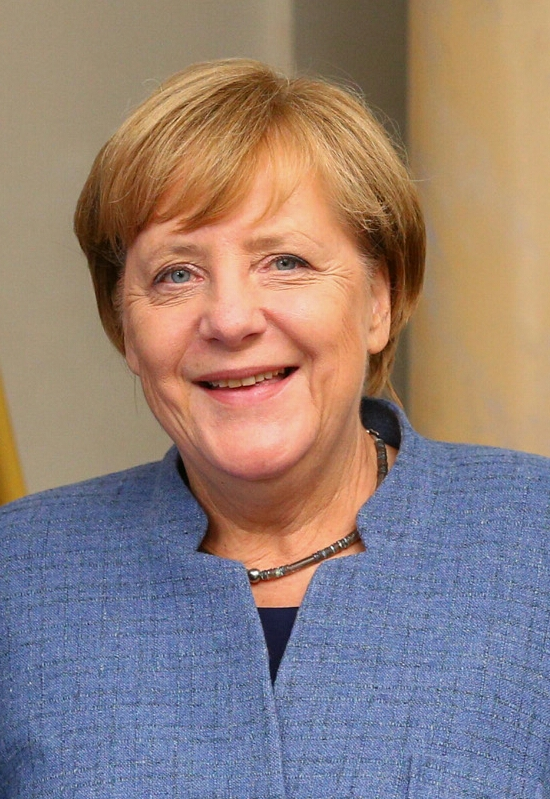

In [13]:
# Download test image
!curl -L -o test.jpg 'https://upload.wikimedia.org/wikipedia/commons/b/bf/Angela_Merkel._Tallinn_Digital_Summit.jpg'

# Restore from checkpoint and do prediction
with tf.Session() as sess:
    saver.restore(sess,  checkpoint)
    %time y = endpoints['Predictions'].eval(feed_dict={file_input: 'test.jpg'})

label_map = imagenet.create_readable_names_for_imagenet_labels()
print('Top 1 prediction: ', y.argmax(), label_map[y.argmax()], y.max())
display.display(display.Image('test.jpg', width=128))

## TensorFlow Lite

<img src='assets/tflite-architecture.jpg' width='500'/>

## Movidius Neural Compute Stick

<img src='assets/ncs_workflow.jpg'/>

[SDK](https://github.com/movidius/ncsdk) for Python, C++ | [Models](https://github.com/movidius/ncappzoo/) for Caffe, TensorFlow

<img src='assets/NCS1_ArchDiagram.jpg'/>

<img src='assets/pi_ncs_objectdetection_table.jpg'/>

[study](https://www.pyimagesearch.com/2018/02/19/real-time-object-detection-on-the-raspberry-pi-with-the-movidius-ncs/)

## Object Detection on the Movidius / Pi 3

In [69]:
from __future__ import print_function
import os
import sys
import platform

import mvnc.mvncapi as mvapi
mvapi.SetGlobalOption(mvapi.GlobalOption.LOG_LEVEL, 0)

# utilities
sys.path += ['/ncappzoo/apps/ssd-object-detector']
from utils import deserialize_output

In [70]:
import numpy as np
import skimage.io
import skimage.transform
import PIL
from IPython import display

# pre-process the test image
IMAGE = 'assets/rub.jpg'
MEAN = 127.5
SCALE = 0.00789

raw_image = skimage.io.imread(IMAGE)
image = skimage.transform.resize(raw_image, [300, 300], preserve_range=True)
image = image[:, :, ::-1] # RGB -> BGR
image = image.astype(np.float16)
image = (image - np.float16(MEAN)) * SCALE

In [71]:
# load the labels
LABELS = '/ncappzoo/caffe/SSD_MobileNet/labels.txt'

labels = [line.rstrip('\n') for line in open(LABELS) if line != 'classes\n']

Linux, raspberrypi, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 
opened Movidius:  1.4
loaded graph:  /ncappzoo/caffe/SSD_MobileNet/graph
execution time: 80.6337 ms
96.0%	15: person: Top Left: (121, 24) Bottom Right: (300, 241)
96.0%	15: person: Top Left: (14, 128) Bottom Right: (300, 299)


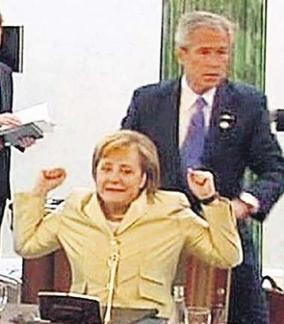

In [72]:
GRAPH = '/ncappzoo/caffe/SSD_MobileNet/graph'

ncs_name = mvapi.EnumerateDevices()[0] # pick the first device
movidius = mvapi.Device(ncs_name)

print(", ".join(platform.uname()))

try:
    movidius.OpenDevice()
    print('opened Movidius: ', ncs_name)

    with open(GRAPH, mode='rb') as f:
        blob = f.read()
    graph = movidius.AllocateGraph(blob)
    print('loaded graph: ', GRAPH)

    # warm start with a dummy forward pass
    graph.LoadTensor(image, 'user object')
    output, userobj = graph.GetResult()

    # actual timed inference
    graph.LoadTensor(image, 'user object')
    output, userobj = graph.GetResult()
    inference_time = graph.GetGraphOption(mvapi.GraphOption.TIME_TAKEN)
    
    # deserialize and print output
    CONFIDENCE_THRESHOLD = 0.60
    output_dict = deserialize_output.ssd(output, CONFIDENCE_THRESHOLD, image.shape)

    print("execution time:", str(np.sum(inference_time)), "ms")

    for i in range(0, output_dict['num_detections']):
        print("%3.1f%%\t" % output_dict['detection_scores_' + str(i)]
               + labels[int(output_dict['detection_classes_' + str(i)])]
               + ": Top Left: " + str(output_dict['detection_boxes_' + str(i)][0])
               + " Bottom Right: " + str(output_dict['detection_boxes_' + str(i)][1]))

    display.display(display.Image(IMAGE))

finally:
    graph.DeallocateGraph()
    movidius.CloseDevice()

## Embedded Learning Library

[Open source library](https://microsoft.github.io/ELL/) developed by Microsoft Research

Uses [OpenBLAS](https://www.openblas.net/) for fast matrix operations

Runs on CPU

[LLVM](https://llvm.org/) optimizer and cross compiler to target embedded platforms

Library of optimized pre-trained models: image classification, keyword detection, transfer learning

Trade off speed and accuracy

## Optimization and cross-compilation

<img src='assets/ell_workflow.png' width='50%'/>

## Speed vs. accuracy tradeoff

<img src='assets/ell_pareto.png'/>

<img src='assets/ell_tiny.png'/>

[model file](https://microsoft.github.io/ELL/gallery/ILSVRC2012/BrazilianGuava.html)

## Speedy Image Classification with ELL

---

Raspberry Pi 3

[DNN Architecture](https://raw.githubusercontent.com/Microsoft/ELL-models/master/models/ILSVRC2012/Chalta/Chalta.cntk.svg?sanitize=true)

In [5]:
# https://microsoft.github.io/ELL/tutorials/Getting-started-with-image-classification-on-the-Raspberry-Pi/

from __future__ import print_function
import sys
import platform
print(", ".join(platform.uname()))
import numpy as np
from matplotlib import pyplot as plt

import cv2
print("OpenCV: ", cv2.__version__)

Windows, ISS8361007390, 10, 10.0.15063, AMD64, Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
OpenCV:  3.4.1


In [ ]:
# load the Object Classifier ELL model
# We are using: https://microsoft.github.io/ELL/gallery/ILSVRC2012/Chalta.html
sys.path += ["/object-classifier/pi3", "/object-classifier/pi3/build", "/"]
import tutorial_helpers as helpers
import model

input_shape = model.get_default_input_shape()
output_shape = model.get_default_output_shape()

# get the labels
with open("/object-classifier/categories.txt", "r") as categories_file:
    categories = categories_file.read().splitlines()

In [13]:
# get the test image
IMAGE = 'assets/dog.jpg'

image = cv2.imread(IMAGE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_data = helpers.prepare_image_for_model(
    image_rgb, input_shape.columns, input_shape.rows, reorder_to_rgb=False, ravel=True)

CPU times: user 712 ms, sys: 0 ns, total: 712 ms
Wall time: 179 ms
(73%) Arctic fox, white fox, Alopex lagopus, (24%) white wolf, Arctic wolf, Canis lupus tundrarum


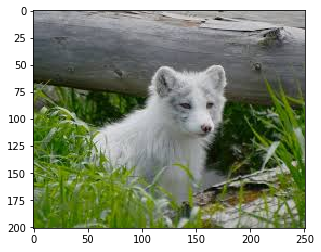

In [14]:
# call the model
%time predictions = model.predict(input_data)

# process the result
top_5 = helpers.get_top_n(predictions, 5)

header_text = ", ".join(["({:.0%}) {}".format(
    element[1], categories[element[0]]) for element in top_5])

plt.imshow(image_rgb)
print(header_text)

## Even smaller? Cortex M?
---
[MXChip IoT DevKit](https://microsoft.github.io/azure-iot-developer-kit/)

<img src='assets/mxweb-12.png' style='float:left;' width='50%'/><img src='assets/EMW3166.png' style='float:right;' width='50%'/>

## Keyword Classification, Cortex M4F

<video controls src='assets/ell_demo.mp4'/>

## MFCC + GRU Audio Keyword Classifier

In [4]:
# !curl -o gru_f_16000_512_160_mel_40_40_log.zip -L  https://github.com/Microsoft/ELL-models/raw/master/models/speech_commands_v0.01/Cinnamon/gru_f_16000_512_160_mel_40_40_log.zip
# !unzip gru_f_16000_512_160_mel_40_40_log.zip
!cat gru_f_16000_512_160_mel_40_40_log.ell

{
  "_type": "Map",
  "_version": "2",
  "model": {
    "_type": "Model",
    "_version": "2",
    "nodes": [
    {
      "_type": "InputNode<float>",
      "_version": "2",
      "id":       "1006",
      "size": 40,
      "shape": [1, 1, 40]
    }, 
    {
      "_type": "NeuralNetworkPredictorNode<float>",
      "_version": "0",
      "id":       "1007",
      "input": {
        "_type": "InputPort<float>",
        "_version": "0",
        "nodeId":         "1007",
        "name": "input",
        "type": 1,
        "input":         "1006.output[0:40]"
      },
      "predictor": {
        "_type": "NeuralNetworkPredictor<float>",
        "_version": "1",
        "inputLayer": {
          "_type": "InputLayer<float>",
          "_version": "0",
          "inputPaddingScheme": 0,
          "inputPaddingSize": 0,
          "outputShape": [1, 1, 40],
          "outputPaddingScheme": 0,
          "outputPaddingSize": 0,
          "data_rows": 1,
          "data_columns": 1,
          "da

          "hiddenWeights_values": [-0.01983546, -0.08122759, -0.04208312, 0.1090897, 0.01985608, 0.4752466, 0.2204366, 0.2583638, 0.2254169, -0.08256869, 0.00636683, 0.06679711, -0.08858112, -0.1094517, 0.1318604, 0.1333775, 0.2100412, 0.1071697, 0.05622408, -0.006774009, -0.08010369, 0.0005921148, 0.07071969, -0.01983958, -0.1288378, 0.01271474, -0.007586794, -0.2098433, -0.1688802, -0.1711058, -0.2785154, -0.09387876, -0.1063264, -0.1927582, -0.02002177, -0.2285583, -0.2333333, -0.1925171, -0.08750043, -0.2118792, 0.5900428, 0.04354408, 0.0004906596, -0.0377156, 0.1829591, -0.2919724, 0.245977, -0.05968768, 0.09831405, 0.198108, -0.05637162, -0.2434394, -0.4406718, -0.09812815, 0.3414455, -0.4747962, 0.3858201, 0.4472592, -0.08257514, -0.2207744, 0.007665823, -0.1316203, -0.08693708, -0.09701727, 0.2082124, -0.2276809, 0.2086758, 0.1628343, -0.1711275, 0.2288086, 0.4219121, 0.2276721, 0.02325981, 0.1695133, -0.009720649, 0.123952, -0.341116, 0.1000888, 0.1007645, -0.05900659, 0.24188

          "updateWeights_values": [-0.08703978, -0.3391505, -0.1017402, -0.07484278, -0.1376885, -0.1279996, 0.1136971, 0.2463484, 0.302559, -0.2306123, -0.01531704, 0.06775824, 0.1366212, 0.147945, -0.04943087, -0.01802591, -0.1360725, -0.08745156, 0.08961703, -0.08444075, 0.1248115, 0.169758, -0.2158169, -0.1200429, -0.4119811, 0.4368093, 0.1315471, -0.275587, 0.1804787, 0.07018268, -0.01866726, -0.1809555, 0.06468093, -0.1137968, -0.01823422, 0.007906944, 0.0818679, -0.2850496, 0.1577346, -0.2186862, 0.07893201, -0.08870522, 0.06468073, 0.02158441, 0.04763158, -0.01907111, -0.2356134, 0.1670645, 0.01422777, -0.2026466, -0.05343506, 0.1863878, 0.06918132, -0.1046818, 0.01971372, -0.01911917, 0.100198, -0.05366958, 0.0583721, -0.0354907, -0.05136757, 0.008278621, -0.4027016, -0.08279364, -0.0768019, 0.03462051, 0.1522962, 0.3354561, -0.2111893, -0.09231979, -0.2341952, 0.04093311, -0.02589001, 0.08396516, 0.2512004, -0.3344567, -0.4131919, 0.2787039, 0.2106055, 0.2182903, 0.1449469, 0

-0.02527071, 0.01517108, -0.09793884, -0.2636767, 0.1960843, 0.3858534, -0.1267193, 0.01521016, 0.1204164, -0.1993179, -0.04719869, -0.04000245, 0.2252936, 0.01877432, 0.1072018, 0.1282609, 0.1029711, -0.4068108, 0.2773239, -0.06817888, 0.1943458, -0.05133753, -0.03189156, -0.0252819, -0.07042316, 0.1897255, -0.04463132, -0.241621, 0.3080216, -0.09126579, -0.0786986, 0.1479785, 0.02544688, 0.3509863, -0.1299226, -0.1140554, 0.2428555, -0.110712, -0.2397197, 0.0866078, 0.2418269, 0.05542564, -0.07083604, 0.2198269, 0.1644814, -0.03715764, 0.06825707, -0.4163696, 0.2061198, 0.3177257, -0.0573968, 0.01472691, -0.1596325, -0.3738798, 0.05249983, -0.2196521, -0.08397254, -0.2613801, -0.07871877, 0.1682748, -0.04657875, 0.2626176, -0.2335391, -0.03750696, 0.210291, -0.1937165, 0.2226555, 0.09397143, -0.2958593, 0.06798388, 0.08378069, 0.01510109, -0.1773273, 0.04888756, 0.05389714, 0.2088756, -0.1340768, -0.0892269, 0.01001756, -0.4842357, 0.1103242, -0.01283185, 0.2590834, -0.05201265, -0.1

          "resetWeights_values": [0.1968396, 0.13474, 0.1815493, -0.08669232, 0.4919392, -0.1480348, 0.03370547, -0.2073299, 0.05477294, 0.3492937, 0.169976, 0.09941239, -0.3231411, -0.2844307, -0.2855818, -0.2683525, 0.5364649, -0.259899, 0.1724741, 0.2426622, 0.3089738, 0.09126689, 0.2881189, -0.3938698, 0.2666265, 0.03490019, 0.3333463, -0.01757748, 0.1242517, 0.1233249, 0.3506388, -0.1313601, -0.09619091, -0.5714554, -0.2980922, 0.05202562, -0.2321796, -0.05129746, -0.06662548, 0.2047405, -0.4527819, 0.2211703, 0.1295667, 0.1618864, -0.4568752, -0.1411131, -0.06356177, -0.778809, 0.2213999, -0.3552153, -0.04603869, 0.1093903, 0.1653787, 0.04572235, -0.1287824, -0.5519559, -0.5156774, 0.4918757, -0.5463294, 0.398878, -0.1092162, 0.4200764, 0.3536324, -0.5759696, -0.0680611, 0.1419358, -0.200977, 0.05754402, 0.1084601, 0.09710658, -0.2905828, 0.01900827, -0.3663394, 0.1698947, -0.2109822, -0.3639964, 0.03988213, 0.09237085, 0.3261699, -0.1694309, 0.3687617, -0.06150621, 0.02416289, -

-0.4678523, -0.07432681, 0.969754, -0.2109915, -0.006771242, 0.2360445, -0.05372987, -0.1395533, 0.1921695, -0.05815686, -0.07813047, -0.3979748, 0.2705277, 0.5363493, -0.1439957, -0.2270676, -0.4682001, 0.08279825, -0.1084091, -0.07484035, -0.03332304, -0.1559316, 0.0153264, 0.3055575, -0.162513, -0.3279651, -0.311927, -0.1520141, -0.3154112, 0.1143274, -0.2688597, 0.1881649, 0.09331243, -0.1669267, 0.4597734, 0.06570702, -0.208496, -0.01507253, -0.2151659, 0.4486986, 0.08305476, 0.1768361, 0.3625672, 0.2502524, -0.4016416, -0.07092377, -0.1283497, 0.1118662, -0.1790073, 0.06133645, -0.1209925, 0.1398702, 0.004632652, -0.4919409, 0.2294393, 0.3114172, -0.1788215, 0.01955464, 0.1198211, 0.3649569, -0.3647006, -0.2039876, 0.4313685, 0.3226084, -0.1327351, 0.2368014, -0.08858875, -0.6374689, 0.09154783, 0.1284186, 0.3870879, -0.1180275, -0.1951974, -0.4443186, 0.1807289, -0.1909488, 0.3975269, 0.03438189, 0.1254861, -0.4655647, 0.225279, 0.008163437, -0.4847221, 0.3206182, 0.06929412, -0

1, -0.005352482, 0.1317106, -0.1277381, 0.5213244, -0.1276002, -0.1448262, -0.1484169, -0.1419132, -0.025575, -0.1570786, 0.03816917, -0.465714, 0.4015748, 0.4775478, 0.02066099, 0.1504944, 0.01312804, 0.06134516, 0.5481338, 0.1622567, 0.06811433, -0.09091234, 0.1464464, 0.0261826, 0.3105084, -0.229248, -0.4068712, 0.6381284, -0.117722, 0.3207718, -0.0686857, -0.03530978, -0.1123357, -0.06033121, -0.2735186, 0.1872262, 0.2702672, -0.2918697, -0.3355768, -0.3511191, -0.1341775, -0.1639854, -0.1414366, -0.2283861, 0.1448815, -0.08004122, 0.01623383, -0.09747397, 0.3546312, 0.06931752, -0.1406863, -0.3256782, -0.1643403, -0.09254964, 0.4556982, -0.036936, 0.1832542, -0.08039224, -0.1977168, -0.1593054, 0.2056348, 0.1935051, 0.09057038, -0.1185195, -0.04272103, 0.1278478, -0.3526443, 0.1379534, -0.1460691, -0.4175797, -0.3540947, -0.005612278, -0.180173, -0.06259305, -0.2903024, -0.2635787, 0.3297025, -0.1231767, -0.1718843, -0.2110393, -0.1667338, 0.1904556, 0.09633123, -0.3735555, -0.372

32689, 0.03839413, 0.1054513, 0.420571, 0.2393771, 0.1283449, 0.009996612, 0.009530385, -0.07617992, 0.1152913, 0.3511472, 0.2419319, 0.1125061, 0.203278, 0.04399193, 0.08933362, -0.2997479, -0.1471072, -0.3498142, -0.241423, 0.1940568, -0.2172206, 0.1173244, -0.05578505, 0.2855836, 0.293472, -0.3058037, 0.1944583, -0.00424253, 0.4051476, 0.1407069, -0.1139926, -0.08331803, 0.1034897, -0.1464206, -0.2339967, -0.08188412, 0.1141511, 0.5387291, 0.155558, -0.6575291, 0.287196, -0.3800417, 0.2673335, -0.3117649, -0.1377737, -0.2981308, 0.4059445, -0.1909183, 0.1556776, -0.2453321, 0.02811139, 0.2611683, -0.1086906, -0.05212435, -0.3885633, 0.02170655, 0.2688968, -0.2257678, -0.01415959, 0.1245605, -0.1128339, -0.1033436, 0.2353223, -0.05086711, -0.4016665, -0.1399936, -0.2453178, 0.114524, 0.0527162, 0.2297444, 0.1861667, 0.404434, 0.3030393, -0.3090897, -0.00240292, -0.02451025, -0.09953718, -0.09445459, -0.01331754, -0.00497891, -0.03726529, -0.8309925, -0.3978087, -0.2940651, -0.0086747

          "hiddenWeights_values": [-0.1553797, 0.2018703, -0.3075794, 0.07858979, 0.2348124, -0.2336498, 0.09108918, -0.3249657, -0.01647759, -0.2626615, 0.03247014, 0.00371844, -0.2763198, -0.05552929, 0.1383843, 0.1140971, -0.1550304, -0.09555431, 0.1061799, -0.06551846, -0.0539952, -0.03425129, 0.2483693, -0.0285041, -0.008461897, -0.04494091, 0.08071411, 0.00171514, 0.06020283, -0.07135223, 0.03803495, 0.1328312, -0.01673127, -0.196163, 0.2200334, 0.1290383, -0.06506378, 0.2416513, -0.138809, 0.02716021, -0.164268, 0.02184701, -0.2465501, 0.3589719, -0.1355242, -0.128487, 0.1472811, 0.06619111, 0.05169074, 0.2609398, 0.2862594, -0.2644669, 0.187166, -0.03419251, -0.33513, -0.4665313, 0.02408328, 0.1441458, 0.2903108, -0.05065597, -0.1104947, 0.2177091, 0.2967977, -0.05318138, 0.03192909, -0.003089754, -0.315592, -0.07487535, 0.3335958, -0.0387574, 0.1251104, 0.04542226, -0.2211828, 0.2418536, 0.193863, 0.09852932, 0.1475736, 0.1001854, -0.1808556, 0.1598748, 0.01475476, -0.2670922,

3243269, 0.1590717, -0.1056129, 0.08869216, -0.102665, -0.3340562, -0.007412458, -0.3928727, -0.0621406, -0.1796584, -0.04781689, -0.1161013, -0.09867376, 0.1352582, 0.7869045, 0.1864138, 0.2649077, 0.1393932, -0.0141185, -0.05277141, -0.1113006, 0.008839714, -0.03833671, -0.07757051, -0.5803689, -0.02568318, 0.3654566, 0.3756357, 0.2145405, 0.05502767, 0.1668292, -0.4463737, 0.233387, 0.1007131, 0.1396236, 0.2422522, -0.2499141, -0.516314, -0.05413843, -0.09663318, -0.04342959, -0.2953993, 0.4248632, -0.1375425, 0.03870873, -0.2485202, 0.1632839, 0.03410488, -0.02912239, -0.1020721, -0.2419003, -0.1153013, -0.1360711, 0.05177841, -0.06642962, 0.4867178, -0.00106132, 0.1241268, -0.2698402, -0.1830151, 0.09965737, -0.2110699, -0.5863557, 0.1960582, -0.3107762, -0.08731544, -0.4214282, -0.1213275, 0.06962797, -0.06070358, 0.5170816, 0.03652527, -0.2562505, -0.1643621, 0.3225039, 0.1846123, -0.0008598415, 0.4310867, -0.4723312, -0.09056424, -0.4211145, -0.09460533, -0.03691877, -0.2210981

103, 0.1172434, -0.6563058, 0.9281942, -0.1171563, 0.1447907, 0.2095896, -0.2476966, 0.3920482, 0.2355756, -0.01131139, -0.3043624, 0.09840387, 0.02954413, -0.0411525, -0.5519324, -0.2259267, -0.1336223, -0.7040188, 0.1829436, -0.3646422, 0.08426879, 0.1352988, 0.2147134, -0.07128402, -0.06123122, 0.0736883, 0.1613777, -0.01034062, 0.05192085, 0.1941459, -0.2419832, -0.4851333, -0.2040823, -0.02388473, -0.3789588, 0.4468209, -0.1324339, -0.06683578, -0.4682252, -0.2233431, 0.03579907, -0.3019935, -0.0354032, -0.545742, -0.2131214, 0.3201754, -0.04165741, 0.3124849, -0.03134449, -0.1223548, -0.5000395, 0.04630636, -0.07986367, 0.02187369, 0.3956251, 0.2237751, -0.1160021, 0.3687716, 0.3571161, -0.3195995, -0.4719745, -0.1753419, 0.4155292, -0.1568148, -0.301444, -0.03899303, -0.2079334, -0.07338972, -0.3550013, 0.2258639, 0.2783473, 0.3859908, -0.2182068, -0.1056703, 0.1407041, -0.2332134, 0.2700537, -0.1812342, 0.1782844, 0.2215587, 0.1179033, 0.2345465, -0.05928455, -0.1237558, 0.1000

.1372374, -0.06208798, 0.1199383, -0.05208616, 0.09514268, 0.008394708, 0.1778717, 0.2050131, 0.08424263, 0.04763396, -0.2756835, 0.3137459, 0.05861677, -0.244155, -0.08661051, 0.3045769, 0.03925989, 0.08945352, -0.1468342, -0.03492241, -0.1594763, -0.2952481, -0.06778741, 0.1299945, -0.1433694, 0.1974782, 0.2021827, -0.3140065, -0.1492423, 0.348943, 0.08800207, -0.002716633, 0.2273242, -0.1696397, -0.06538387, -0.1268253, -0.1194711, -0.2216271, -0.1897313, 0.2269812, -0.1786927, -0.0644822, -0.06378432, 0.07512534, -0.05717054, 0.2573447, 0.4791636, 0.09773507, 0.0639973, 0.045306, -0.4271825, -0.07997912, 0.05762478, 0.1559143, 0.1241678, 0.1768654, 0.0359332, -0.8857027, 0.01482434, -0.190671, -0.3433253, 0.1213354, 0.2143381, -0.03579855, -0.1637135, 0.346971, 0.4664128, -0.1527117, 0.3522882, 0.0005101087, 0.07280358, 0.3091012, -0.5403427, -0.1311618, 0.1155767, -0.0153247, -0.03539892, -0.1991289, -0.2916338, 0.2638924, -0.1222264, -0.006907801, -0.4554735, -0.2229841, 0.158112

098, -0.2497216, -0.3895073, -0.08085278, 0.2890812, -0.09987444, -0.2170566, -0.1938159, -0.06083123, -0.06716471, -0.2087748, 0.05617842, 0.4584523, -0.4404057, -0.1245233, 0.210892, -0.03104315, 0.1434723, 0.1761211, 0.08688836, 0.1237894, 0.4559473, 0.02261287, 0.1957729, 0.1444824, 0.453165, -0.0774796, -0.009989649, 0.44488, -0.3513686, 0.2765152, -0.342914, -0.1181043, 0.5348991, -0.4351314, 0.05772009, -0.1469111, 0.0589998, 0.2848557, -0.2659025, 0.1381261, 0.3243996, 0.1058363, 0.2590081, -0.05802008, 0.493137, 0.3941095, 0.1471029, 0.1020502, 0.03265337, 0.4249917, -0.06422448, -0.105655, 0.06988634, -0.05377714, -0.1316333, 0.03719251, 0.05782362, -0.09121697, 0.06887549, 0.2177917, 0.4722704, 0.6939842, -0.3978547, 0.093264, -0.05830812, 0.2763955, 0.3913377, -0.133586, -0.1766269, 0.01289905, -0.5028111, 0.2915778, 0.2996725, 0.08815376, -0.03391008, -0.2929493, -0.1477463, 0.03695229, -0.1820108, 0.2090179, -0.1487527, 0.2609042, 0.264724, 0.4107331, -0.1689385, -0.19856














































}

In [5]:
# !curl -o f_16000_512_160_mel_40_40_log.zip -L  https://github.com/Microsoft/ELL-models/raw/master/models/speech_commands_v0.01/Cinnamon/f_16000_512_160_mel_40_40_log.zip
# !unzip f_16000_512_160_mel_40_40_log.zip
!cat f_16000_512_160_mel_40_40_log.ell

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   207  100   207    0     0    481      0 --:--:-- --:--:-- --:--:--   482
100   691  100   691    0     0    721      0 --:--:-- --:--:-- --:--:--  1489
Archive:  f_16000_512_160_mel_40_40_log.zip
  inflating: f_16000_512_160_mel_40_40_log.ell  
{
  "_type": "Map",
  "_version": "2",
  "model": {
    "_type": "Model",
    "_version": "2",
    "nodes": [
    {
      "_type": "InputNode<float>",
      "_version": "2",
      "id":       "1068",
      "size": 160,
      "shape": [160, 1, 1]
    }, 
    {
      "_type": "BufferNode<float>",
      "_version": "0",
      "id":       "1069",
      "input": {
        "_type": "InputPort<float>",
        "_version": "0",
        "nodeId":         "1069",
        "name": "input",
        "type": 1,
        "input":         "1068.output[0:160]"
      },
      "windowSize": 512
    }, 
  

In [ ]:
# https://microsoft.github.io/ELL/tutorials/Getting-started-with-audio-keyword-classification-on-the-Raspberry-Pi/

from __future__ import print_function
import os
import sys
import platform
print(", ".join(platform.uname()))
import numpy as np

# load the ELL audio helper code
sys.path += ["/ELL/tools/utilities/pythonlibs/audio"]
import classifier
import featurizer
import wav_reader

In [ ]:
CLASSIFIER = "/speech-cmds/classifier_16k/model"
FEATURIZER = "/speech-cmds/featurizer_16k/mfcc"
CATEGORIES = "/speech-cmds/categories.txt"

THRESHOLD = 0.6 # only report predictions with greater than 60% confidence
SAMPLE_RATE = 16000 # classifier was trained on 16kHz samples
CHANNELS = 1 # classifier was trained on mono audio
SMOOTHING = 0.2 # 0.2 second smoothing window on classifier output
NOISE_LABEL = [0] # tell classifier to ignore predictions of background noise

predictor = classifier.AudioClassifier(CLASSIFIER, CATEGORIES, NOISE_LABEL, THRESHOLD, SMOOTHING)
transform = featurizer.AudioTransform(FEATURIZER, predictor.input_size)

In [ ]:
wav_file = '/ELL/docs/tutorials/Getting-started-with-audio-classification-on-the-Raspberry-Pi/seven.wav'

reader = wav_reader.WavReader(SAMPLE_RATE, CHANNELS)
reader.open(wav_file, transform.input_size)
transform.open(reader)

In [ ]:
while True:
    feature_data = transform.read()
    if feature_data is None:
        break
    else:
        prediction, probability, label = predictor.predict(feature_data)
        if probability is not None:          
            percent = int(100 * probability)
            print("<<< DETECTED ({}) {}% {} >>>".format(prediction, percent, label))

Test data: https://www.text2speech.org/

In [ ]:
!cat /speech-cmds/categories.txt

In [ ]:
# !curl -o speech.wav -L 'https://www.text2speech.org/FW/getfile.php?file=3826f2e422a656b3920c9c315a296924%2Fspeech.wav'
# !curl -o speech.wav -L 'https://www.text2speech.org/FW/getfile.php?file=5eb5956a8853bccf26bd721e798589c3%2Fspeech.wav'
# wav_file = 'speech.wav'

## Programmable, highly optimized hardware?
---
<img src='assets/Hot-Chips-Stratix-10-board-1-.jpg'/>

<img src='assets/silicon_alternatives.png'/>

https://www.microsoft.com/en-us/research/blog/microsoft-unveils-project-brainwave/

## FPGA: Neural Net Accelerators
- [comparison study](https://arxiv.org/abs/1712.08934)
- [Xilinx](https://github.com/Xilinx/RFNoC-HLS-NeuralNet)
- [PipeCNN](https://github.com/doonny/PipeCNN)

<img src='assets/Demo-DE5-net.gif'/>

## Deploy to an FPGA via Azure
---
[Azure Real Time AI: ResNet50](https://github.com/Azure/aml-real-time-ai/blob/master/notebooks/resnet50/00_QuickStart.ipynb)

## What we covered

- Running AI on devices _can_ improve responsiveness, address privacy risks

- Optimized deep learning models are available today

- Many ways to deploy models on devices
  - CoreML
  - TensorFlow / TensorFlow Lite
  - Offloaded (e.g. Movidius)
  - Embedded Learning Library
  - FPGAs

## Thank you!
---
<img src='assets/stackup-banner.png' style='float:left;'/>
<img src='assets/fb-128x128.png' width='96'/>facebook.com/groups/stackup
<img src='assets/Octicons-mark-github.svg' width='5%'/>github.com/lisaong/stackup-workshops

[Survey](https://www.mentimeter.com/s/21766e2bbf0395ac216695c825dab352/4945f7d8aea3)

## Bonus Demo
---
Visualizing MobileNet V1 using Keras on Raspberry Pi 3

In [1]:
# Reference: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

# if running on python 3.6, may need this:
# !conda install pillow=4.1.1

import numpy as np
import platform
print(", ".join(platform.uname()))
import keras
print("Keras:", keras.__version__)
from keras.applications import mobilenet
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
from matplotlib.pyplot import imshow
import time

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128
img_path = 'assets/dog.jpg'

# Load a MobileNet network with ImageNet weights
print('Loading MobileNet v1 ....')
model = mobilenet.MobileNet(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)

model.summary()

Linux, bb9db747cd55, 4.14.34-v7+, #1110 SMP Mon Apr 16 15:18:51 BST 2018, armv7l, 


/usr/lib/python3/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Keras: 2.1.6
Loading MobileNet v1 ....
17227776/17225924 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
______________________________________

In [2]:
def preprocess_image(image_path):
    """Opens, resize and format pictures into tensors"""
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = mobilenet.preprocess_input(img)
    return img

def deprocess_image(x):
    """Converts a tensor into a valid image"""
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    """Normalizes a tensor by its L2 norm""" 
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [3]:
# name of the layer and max number of filters to visualize
# (see model definition at keras/applications/mobilenet.py)
layer_name = 'conv_dw_3'
max_filters = 32
epochs = 30

input_img = model.input
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

kept_filters = [] # candidate filters to display

for filter_index in range(max_filters):

    # scan through the first max_filters filters
    # max_filters must be less than the actual number of filters in each layer
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # ==========================================
    # 1. build a loss function that maximizes the activation
    #    of the nth filter of our selected layer
    layer_output = layer_dict[layer_name].output    
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
   
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    
    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # return the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    
    # ==========================================
    # 2. now run gradient ascent
    input_img_data = preprocess_image(img_path)
    step_size = 1.
    
    for i in range(epochs):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step_size

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # ===========================================
    # 3. decode the resulting input image and store in kept_filters
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 1.746841
Current loss value: 1.5390297
Current loss value: 2.74441
Current loss value: 3.635646
Current loss value: 4.3795075
Current loss value: 5.013916
Current loss value: 5.521706
Current loss value: 5.970072
Current loss value: 6.347291
Current loss value: 6.8545547
Current loss value: 7.253422
Current loss value: 7.5773053
Current loss value: 7.9600377
Current loss value: 8.186979
Current loss value: 8.385626
Current loss value: 8.864298
Current loss value: 9.141331
Current loss value: 9.305442
Current loss value: 9.565673
Current loss value: 9.800308
Current loss value: 10.025774
Current loss value: 10.154406
Current loss value: 10.264089
Current loss value: 10.381666
Current loss value: 10.601126
Current loss value: 10.822943
Current loss value: 10.864773
Current loss value: 10.969705
Current loss value: 11.132976
Current loss value: 11.407114
Filter 0 processed in 16s
Processing filter 1
Current loss value: -12.047959
Filter 1 processed 

Current loss value: 10.028311
Current loss value: 28.349066
Current loss value: 30.44645
Current loss value: 31.969765
Current loss value: 32.914932
Current loss value: 33.531937
Current loss value: 33.933372
Current loss value: 34.37256
Current loss value: 34.409306
Current loss value: 34.61219
Current loss value: 34.839718
Current loss value: 35.106922
Current loss value: 35.105335
Current loss value: 35.220497
Current loss value: 35.29332
Current loss value: 35.31762
Current loss value: 35.39327
Current loss value: 35.45862
Current loss value: 35.41832
Current loss value: 35.50872
Current loss value: 35.51449
Current loss value: 35.48281
Current loss value: 35.4405
Current loss value: 35.470078
Current loss value: 35.493946
Current loss value: 35.548077
Current loss value: 35.49018
Current loss value: 35.549232
Current loss value: 35.52014
Current loss value: 35.526276
Filter 18 processed in 17s
Processing filter 19
Current loss value: 0.0039050959
Current loss value: 0.05449607
Cur

16


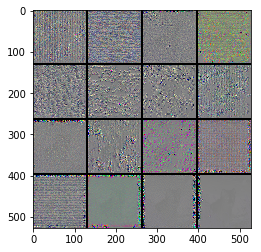

In [4]:
# ===========================================
# 4. stich the best 16 filters on a 4 x 4 grid.
n = 4
print(len(kept_filters))

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 16 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 4 x 4 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img


imshow(stitched_filters)